In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from tqdm.auto import tqdm

#### Get dataset faces of people

In [234]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t')
    df_attrs = pd.DataFrame(df_attrs)


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
data, attrs = fetch_dataset()
data = data.astype(np.float32)

#### Split dataset to train and test, make dataloader

In [5]:
train_data, test_data = data_utils.random_split(data, [0.8, 0.2])
train_loader = data_utils.DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
test_loader = data_utils.DataLoader(test_data, batch_size=32, shuffle=True, pin_memory=True)

#### Define AE architecture

In [ ]:
dim_code = 16 # latent dim

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            self.relu,
            nn.Conv2d(32, 24, kernel_size=7, padding=3),
            nn.BatchNorm2d(24),
            self.relu,
            nn.Conv2d(24, 16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
            self.relu,
        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 24, kernel_size=7, padding=3),
            nn.BatchNorm2d(24),
            self.relu,
            nn.ConvTranspose2d(24, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            self.relu,
            nn.ConvTranspose2d(32, 3, kernel_size = 7, padding=3)
        )

    def forward(self, x):
        x = x.view(-1, 3, 64, 64)
        latent_code = self.Encoder(x)
        reconstruction = self.Decoder(latent_code)
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        return reconstruction, latent_code

In [10]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [51]:
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4, amsgrad=True)

#### Learn out AE

In [52]:
n_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = autoencoder(X_batch.to(device))[0]
        loss = criterion(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in test_loader:
          reconstructed = autoencoder(X_batch.to(device))[0]
          loss = criterion(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    print(f"Epoch {epoch} train loss {train_losses[-1]} val loss {val_losses[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 train loss 0.029514198182971643 val loss 0.007085871018738632
Epoch 1 train loss 0.0064983129696665745 val loss 0.005384337903191167
Epoch 2 train loss 0.005224274163556181 val loss 0.0066206582305750935
Epoch 3 train loss 0.004088817893932248 val loss 0.0036704825063471696
Epoch 4 train loss 0.0036430287912295493 val loss 0.0027992400222917996
Epoch 5 train loss 0.003101791853175745 val loss 0.0029201000081711865
Epoch 6 train loss 0.0030924811347820837 val loss 0.003534717502139778
Epoch 7 train loss 0.0027064903629349267 val loss 0.0019456581142450493
Epoch 8 train loss 0.002646062399634361 val loss 0.002411579056811261
Epoch 9 train loss 0.0025587505614951163 val loss 0.003199829464688538


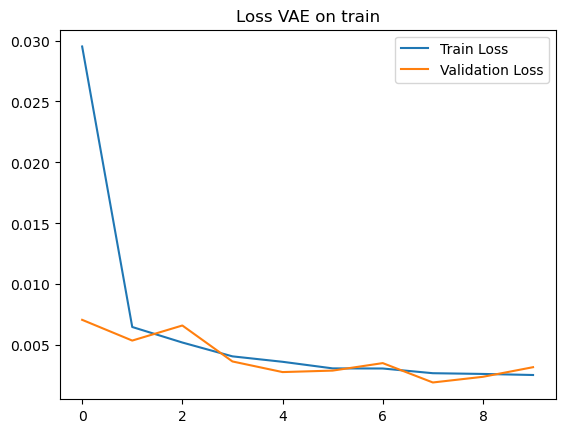

In [53]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss VAE on train')
plt.legend()
plt.show()

#### Let's see how our AE recreate pictures

In [57]:
torch.save(autoencoder, './model_weights')

In [54]:
val_batch = next(iter(test_loader))

In [55]:
with torch.no_grad():
    reconstruction = autoencoder(val_batch.to(device))[0]
    result = reconstruction.cpu().detach().numpy()
    ground_truth = val_batch.numpy()


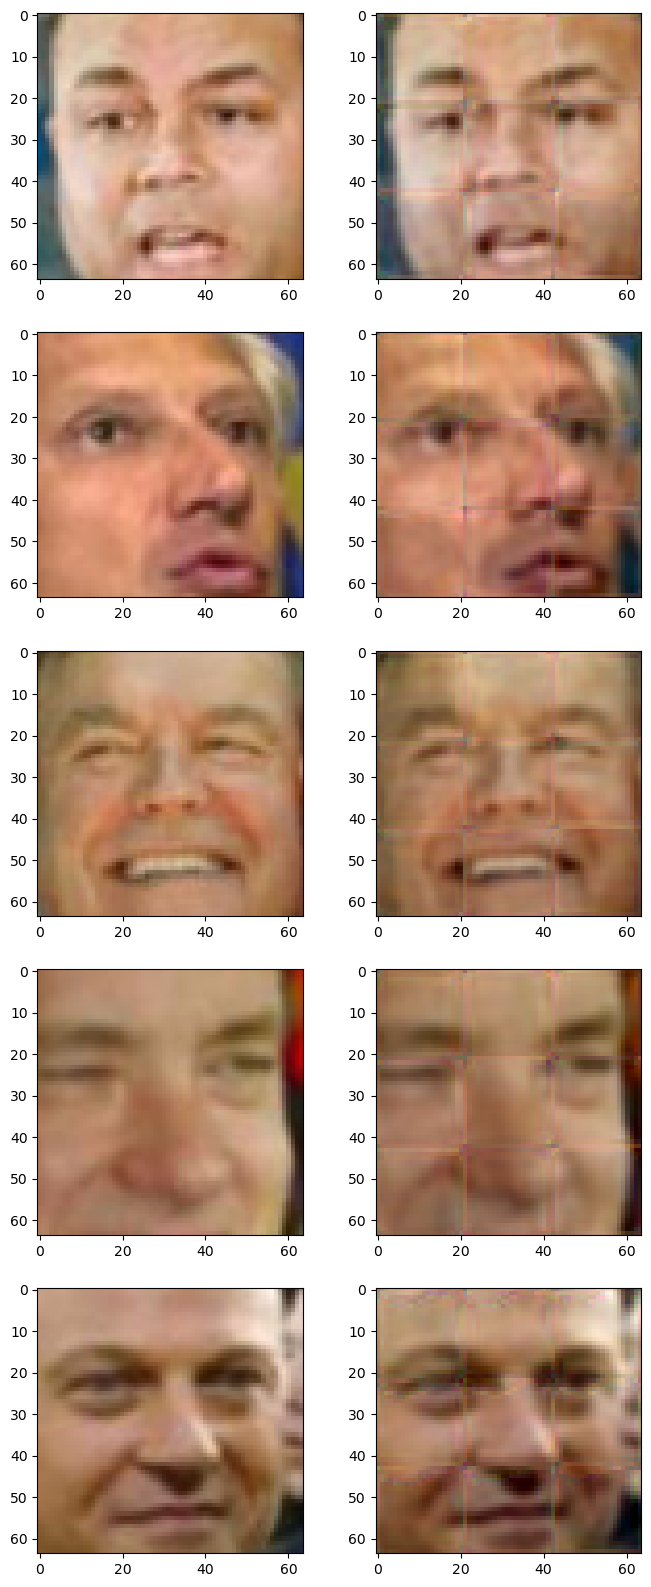

In [56]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(np.clip(res, .0, 1.))

Not bad, right?

#### Let's sample from our latent space

In [ ]:
res = None
with torch.no_grad():
    for i, x_b in enumerate(train_loader):
        preds = autoencoder(x_b.to(device))[1].cpu().detach()
        if i == 0:
            res = preds
            continue
        res = torch.vstack((res, preds))

In [59]:
res.shape

torch.Size([10515, 16, 64, 64])

In [60]:
import gc

gc.collect()

torch.mps.empty_cache()

In [ ]:
train_mean = torch.mean(res, dim=(0)).to(torch.float32)
train_std = torch.std(res, dim=(0)).to(torch.float32)

In [ ]:
z = torch.randn(25, 16, 64, 64).to(torch.float32)
z = z * train_std + train_mean
output = autoencoder.Decoder(z.to(device)).view(-1, 64, 64, 3).cpu().detach().numpy()
output.shape

(25, 64, 64, 3)

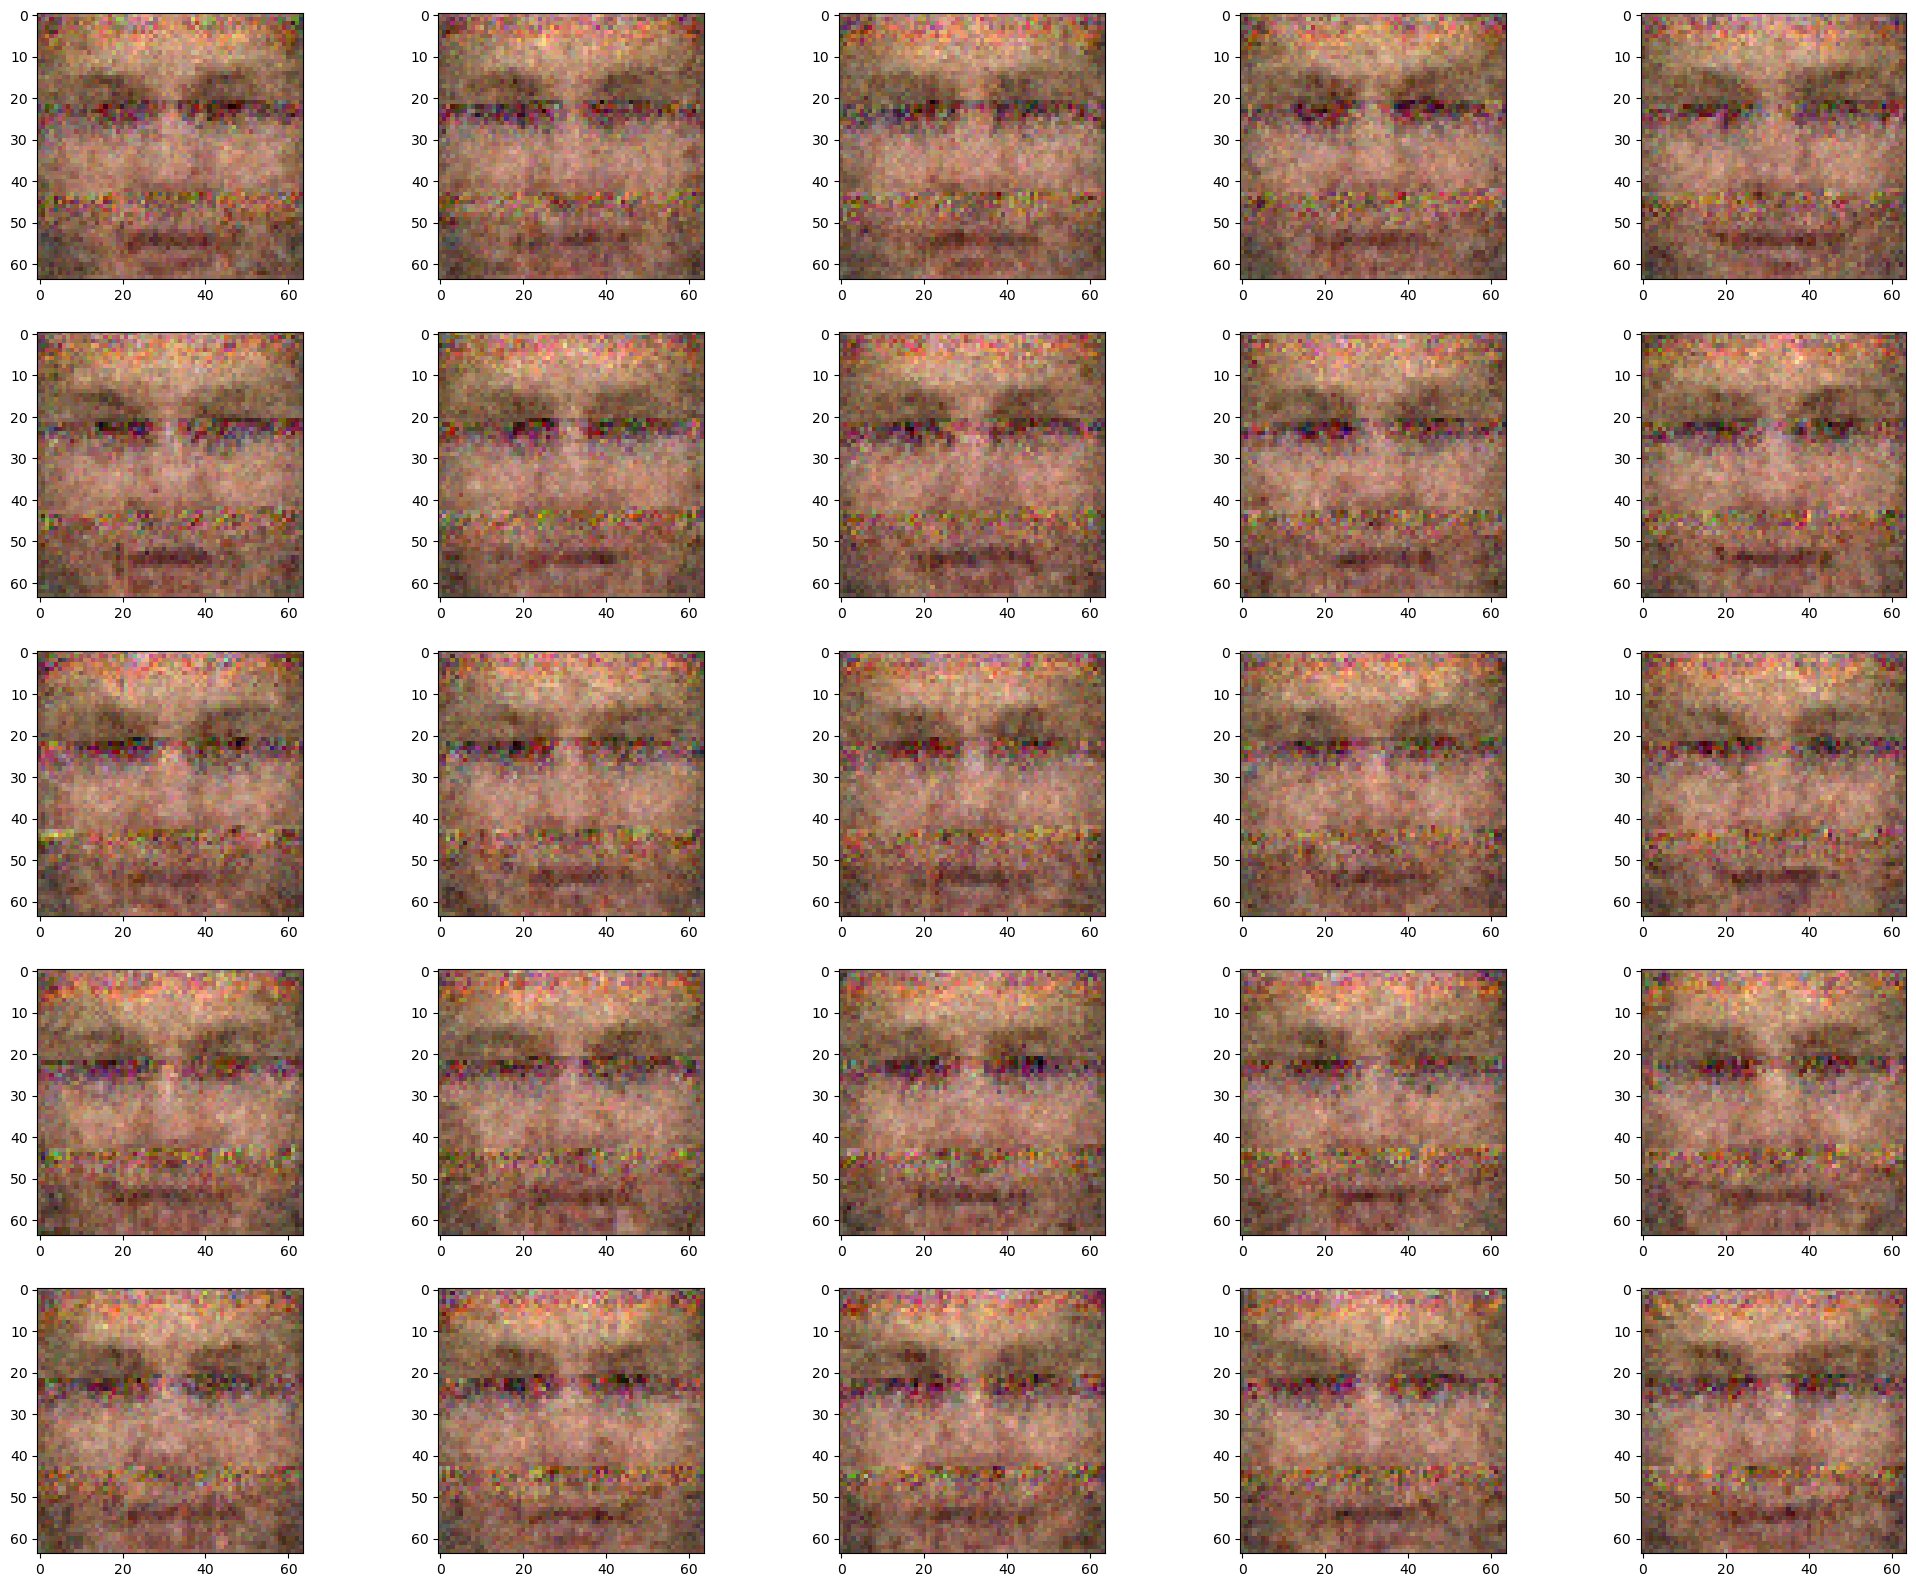

In [67]:
plt.figure(figsize=(25, 20))
for i in range(output.shape[0]):
    plt.subplot(5, 5, i + 1)
    generated = output[i]
    plt.imshow(np.clip(generated, 0, 1))

plt.show()

#### Let's make our people smiling

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

In [68]:
df = pd.read_csv('./lfw_attributes.txt', sep='\t')
df.head()

,person,imagenum,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,Aaron Eckhart,1,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.195580,-0.835609,-0.351468,...,0.361738,1.166118,-1.164916,-1.139990,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,Aaron Guiel,1,0.169851,-0.982408,0.422709,-1.282184,-1.360060,-0.867002,-0.452293,-0.197521,...,-0.832036,-0.397680,0.874160,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.666760,-0.496559
2,Aaron Patterson,1,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,Aaron Peirsol,1,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,Aaron Peirsol,2,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.082680,-0.439614,-0.359859,-0.760774,-0.410152


In [69]:
smiling = df['Smiling'].sort_values(ascending=False)[:15]
smile_idx = smiling.reset_index().iloc[:, 0].astype(int).to_numpy()

smile_data = torch.tensor(data[smile_idx].astype(np.float32))

In [70]:
not_smile_idx = df['Smiling'].sort_values(ascending=True)[:15].reset_index().iloc[:, 0].astype(int).to_numpy()
not_smile_idx

not_smile_data = torch.tensor(data[not_smile_idx].astype(np.float32))

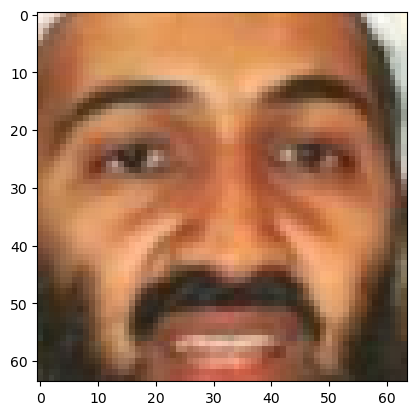

In [71]:
plt.imshow(data[9690])
plt.show();

In [72]:
smile_data.shape, not_smile_data.shape

(torch.Size([15, 64, 64, 3]), torch.Size([15, 64, 64, 3]))

In [73]:
latent_smile = autoencoder(smile_data.to(device))[1].detach().cpu()

latent_not_smile = autoencoder(not_smile_data.to(device))[1].detach().cpu()

In [74]:
latent_smile.shape, latent_not_smile.shape

(torch.Size([15, 16, 64, 64]), torch.Size([15, 16, 64, 64]))

In [75]:
smile_vector = latent_smile.mean(0) - latent_not_smile.mean(0)

In [76]:
smile_vector.shape

torch.Size([16, 64, 64])

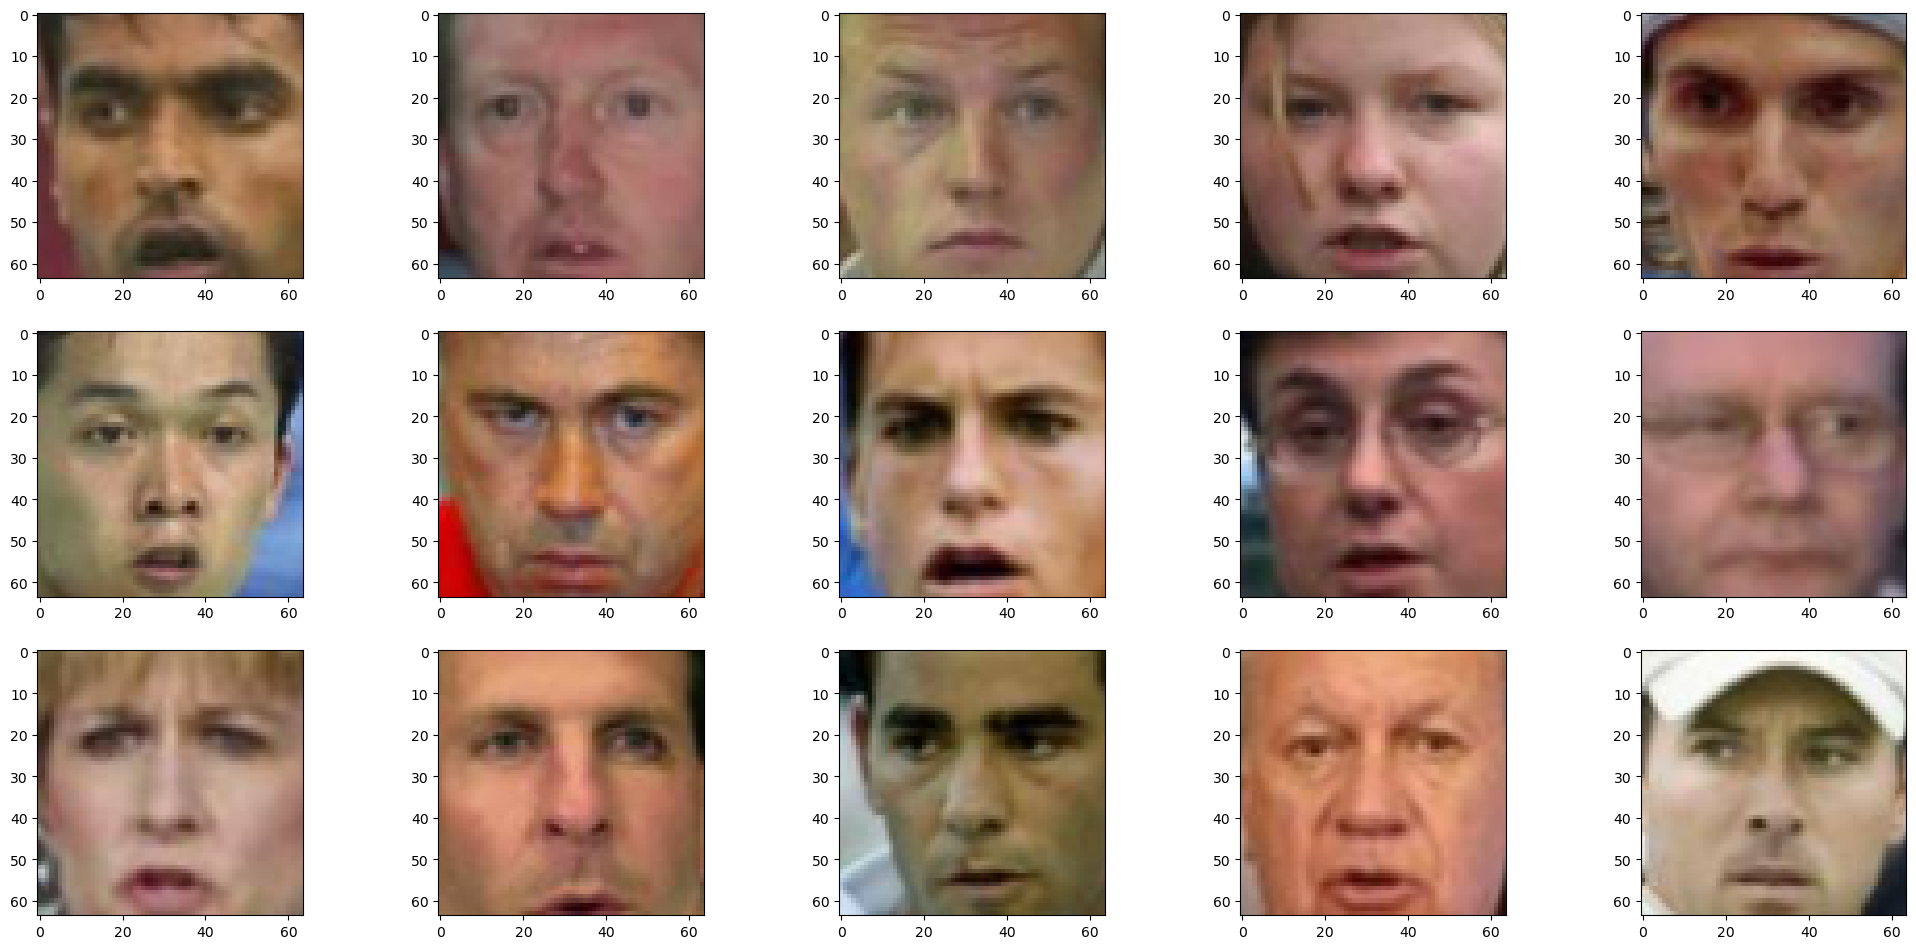

In [77]:
plt.figure(figsize=(25, 20))
for i in range(not_smile_data.shape[0]):
    plt.subplot(5, 5, i + 1)
    generated = not_smile_data[i]
    plt.imshow(generated)

plt.show()

In [78]:
latent_data = latent_not_smile + smile_vector
latent_data.shape

torch.Size([15, 16, 64, 64])

In [79]:
nsmile_to_smile = autoencoder.Decoder(latent_data.to(device)).view(-1, 64, 64, 3).detach().cpu().numpy()

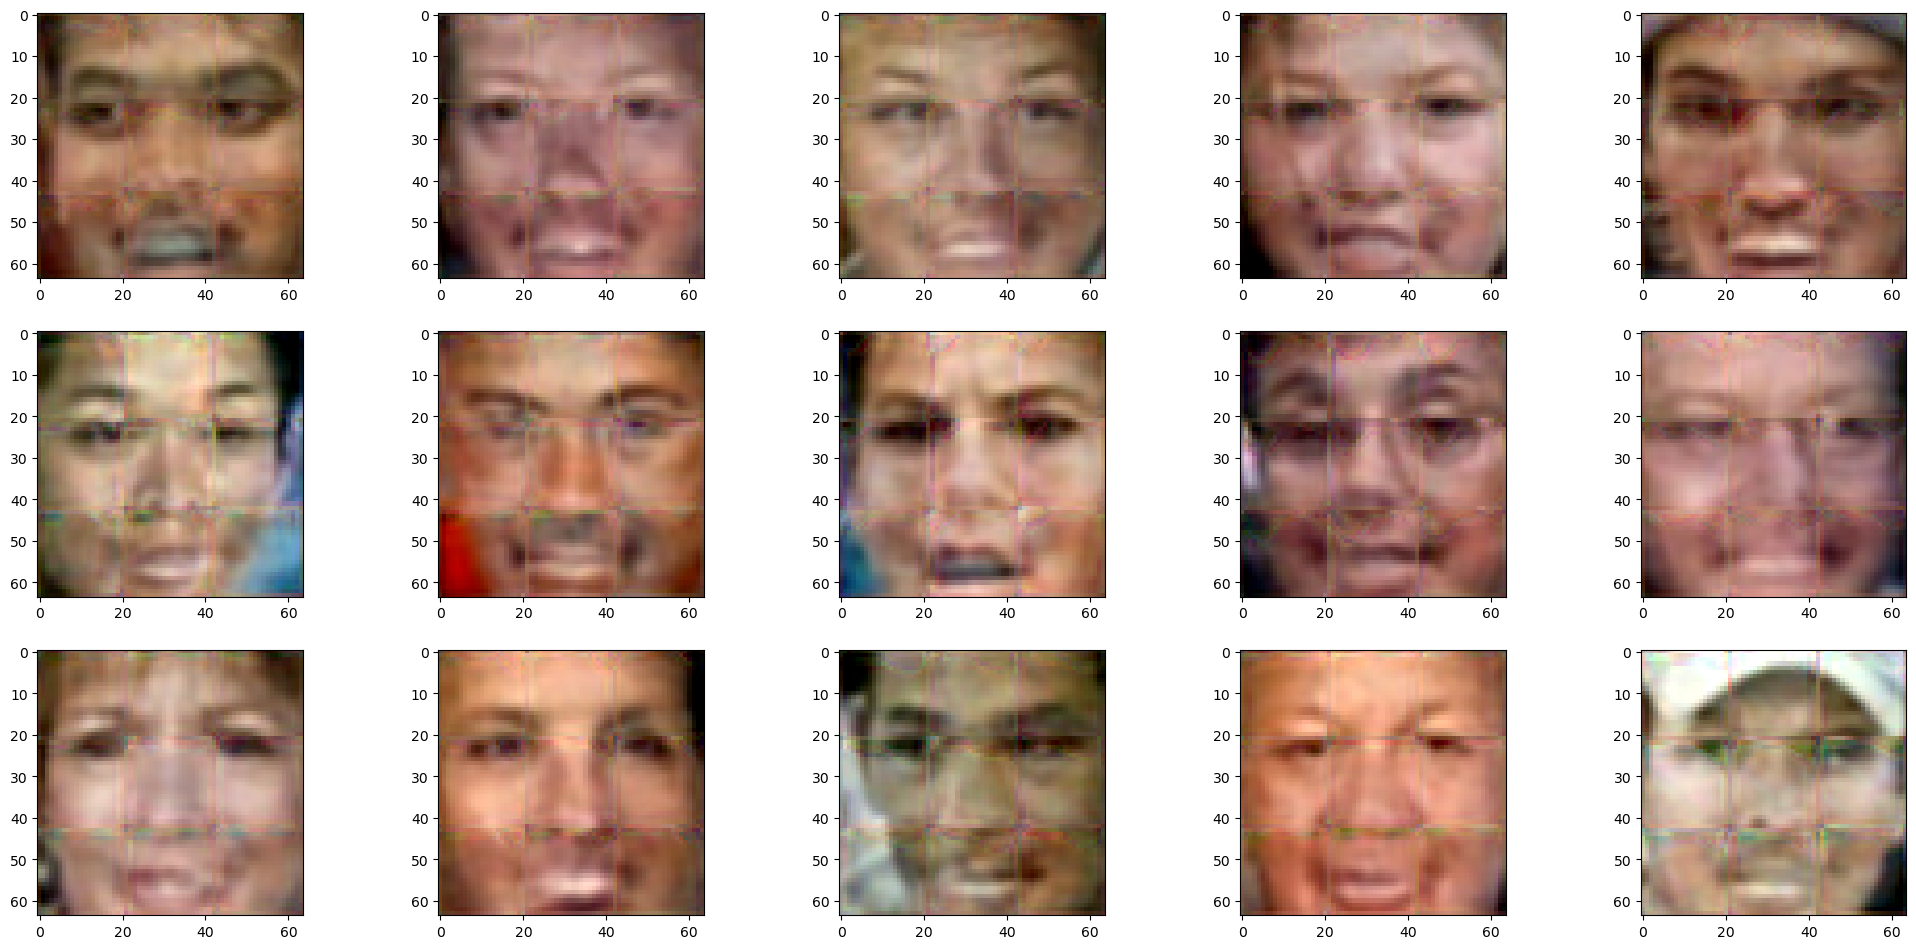

In [80]:
plt.figure(figsize=(25, 20))
for i in range(nsmile_to_smile.shape[0]):
    plt.subplot(5, 5, i + 1)
    generated = nsmile_to_smile[i]
    plt.imshow(np.clip(generated, 0, 1))

plt.show()

#### Now let's define VAE

In [7]:
batch_size = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=torchvision.transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [8]:
features = 4

In [9]:
class VAE(nn.Module):
    def __init__(self):
       super(VAE, self).__init__()
       self.silu = nn.SiLU(inplace=True)
       self.Encoder = nn.Sequential(
           nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2), # 14
           nn.BatchNorm2d(16),
           self.silu,
           nn.Conv2d(16, 8, kernel_size=5, stride=2, padding=2), # 7
           nn.BatchNorm2d(8),
           self.silu,
           nn.Conv2d(8, 4, kernel_size=5, stride=2, padding=2), # 4
           nn.BatchNorm2d(4),
           self.silu,
           nn.Flatten(),
           nn.Linear(4 * 4 * 4, features * 2),
           nn.BatchNorm1d(features * 2),
           self.silu
       )
       self.fc_decode = nn.Sequential(
            nn.Linear(features, 4 * 4 * 4),
            nn.BatchNorm1d(4 * 4 * 4),
            self.silu
        )

       self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(8),
            self.silu,
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(16),
            self.silu,
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
       )

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.Encoder(x)
        x = x.view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = eps * std + mu
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        z = self.fc_decode(z)
        z = z.view(-1, 4, 4, 4)
        reconstruction = self.Decoder(z)
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [10]:
vae = VAE()

In [11]:
mu, logsigma, reconstructed = vae(torch.randn(32, 1, 28, 28))

In [12]:
mu.shape, logsigma.shape, reconstructed.shape

(torch.Size([32, 4]), torch.Size([32, 4]), torch.Size([32, 1, 28, 28]))

#### Define VAE loss (KL-divergence and log_likelihood)

In [58]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp(), dim=1)
    return torch.mean(loss)

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = torch.nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return log_likelihood(x, reconstruction) - KL_divergence(mu, logsigma)

In [59]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [60]:
criterion = loss_vae

autoencoder = VAE().to(device)

In [61]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 1e-3, amsgrad = True)

In [62]:
epochs = 10
train_losses = []
val_losses = []


for epoch in tqdm(range(epochs)):
    autoencoder.train()
    train_loss_epoch = []
    for X_b, _ in train_loader:
        optimizer.zero_grad()
        X_b = X_b.to(device)
        mu, logsigma, reconstr = autoencoder(X_b)
        loss = criterion(X_b, mu, logsigma, reconstr)
        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())
    train_losses.append(np.mean(train_loss_epoch))

    autoencoder.eval()
    val_loss_epoch = []
    with torch.no_grad():
        for X_t, _ in test_loader:
            X_t = X_t.to(device)
            mu, logsigma, reconstr = autoencoder(X_t)
            loss = criterion(X_t, mu, logsigma, reconstr)
            val_loss_epoch.append(loss.item())
    val_losses.append(np.mean(val_loss_epoch))
    print(f"Epoch: {epoch}; train loss: {train_losses[-1]}; val loss: {val_losses[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0; train loss: 28883.331623134327; val loss: 21760.48333353936
Epoch: 1; train loss: 22161.599515674974; val loss: 19622.27237131626
Epoch: 2; train loss: 20851.717155017323; val loss: 18760.576827037185
Epoch: 3; train loss: 20126.424554820762; val loss: 18223.792152887658
Epoch: 4; train loss: 19619.689219916047; val loss: 17875.542684434335
Epoch: 5; train loss: 19236.961289395655; val loss: 17646.84351513054
Epoch: 6; train loss: 18956.223387110207; val loss: 17338.08793080004
Epoch: 7; train loss: 18723.85097114872; val loss: 17221.383374950554
Epoch: 8; train loss: 18525.548351295976; val loss: 17076.88320806962
Epoch: 9; train loss: 18353.372199410314; val loss: 16967.318526255935


#### Let's see how our VAE create images

In [63]:
X_a = next(iter(test_loader))[0].to(device)
preds = autoencoder(X_a)[2].detach().cpu().numpy()[10:20]

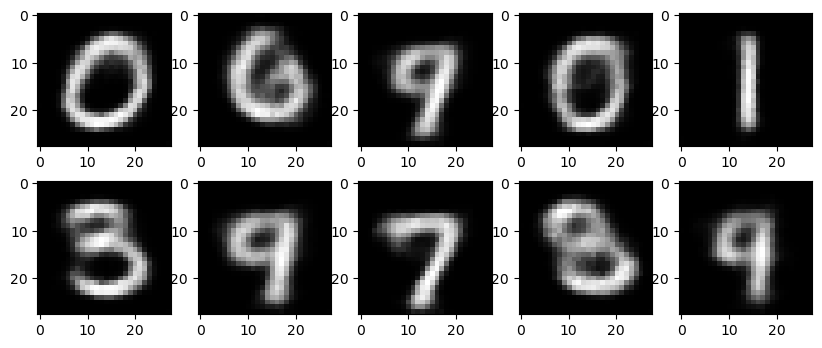

In [64]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(preds[i].reshape(28, 28, 1), cmap='gray')

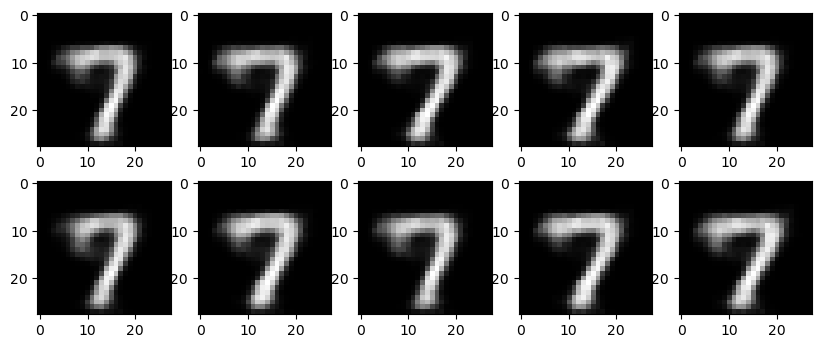

In [ ]:
autoencoder.eval()
z = np.array([np.random.normal(0, 1, 4) for i in range(10)])
output = autoencoder.decode(torch.FloatTensor(z).to(device)).detach().cpu().numpy()

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(output[i].reshape(28, 28, 1), cmap='gray')

#### Let's see on VAE latent space

In [ ]:
mu_latent = None
with torch.no_grad():
    for i, x_b in enumerate(test_loader):
        mu = autoencoder(x_b[0].to(device))[0]
        mu = mu.cpu().detach()
        if i == 0:
            mu_latent = mu
            continue
        mu_latent = torch.vstack([mu_latent, mu])

mu_latent.shape

torch.Size([10000, 4])

In [96]:
from sklearn.manifold import TSNE
tsne = TSNE(2, n_jobs=-1)
tsne_result = tsne.fit_transform(mu_latent.detach().numpy())

In [99]:
tsne_result.shape

(10000, 2)

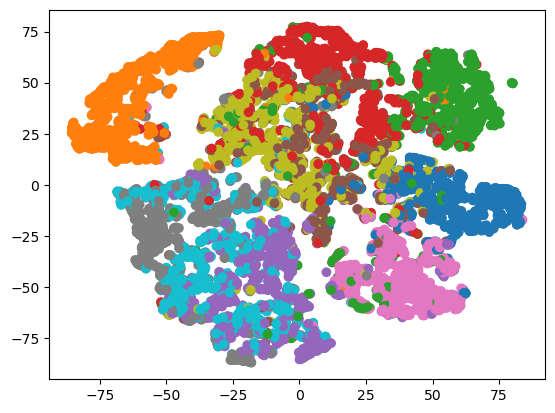

In [122]:
plt.scatter(x=tsne_result[:, 0], y=tsne_result[:, 1], c=test_dataset.targets.numpy(), cmap='tab10')
plt.show()

#### Let's create Conditional VAE, which can generate images by passing class name in latent space


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



In [141]:
features = 4

In [165]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.silu = nn.SiLU(inplace=True)
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=2), # 14
            nn.BatchNorm2d(16),
            self.silu,
            nn.Conv2d(16, 8, kernel_size=5, padding=2, stride=2), # 7
            nn.BatchNorm2d(8),
            self.silu,
            nn.Conv2d(8, 4, kernel_size=5, padding=2, stride=2), # 4
            nn.BatchNorm2d(4),
            self.silu,
            nn.Flatten(),
            nn.Linear(4 * 4 * 4, features * 2),
            nn.BatchNorm1d(features * 2),
            self.silu
        )

        self.fc_decode = nn.Sequential(
            nn.Linear(features + 1, 4 * 4 * 4),
            nn.BatchNorm1d(4 * 4 * 4),
            self.silu
        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=5, padding=2, stride=2),
            nn.BatchNorm2d(8),
            self.silu,
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(16),
            self.silu,
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        x = self.Encoder(x)
        x = x.view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        class_num = class_num.view(-1, 1)
        z = torch.cat([z, class_num], dim=-1)
        z = self.fc_decode(z)
        z = z.view(-1, 4, 4, 4)
        reconstruction = self.Decoder(z)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [166]:
criterion = loss_vae

autoencoder = CVAE().to(device)

In [196]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 3e-4, amsgrad=True)

In [198]:
epochs = 5
train_losses = []
val_losses = []


for epoch in tqdm(range(epochs)):
    autoencoder.train()
    train_loss_epoch = []
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        X_b = X_b.to(device)
        y_b = y_b.to(device)
        mu, logsigma, reconstr = autoencoder(X_b, y_b)
        loss = criterion(X_b, mu, logsigma, reconstr)
        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())
    train_losses.append(np.mean(train_loss_epoch))

    autoencoder.eval()
    val_loss_epoch = []
    with torch.no_grad():
        for X_t, y_t in test_loader:
            X_t = X_t.to(device)
            y_t = y_t.to(device)
            mu, logsigma, reconstr = autoencoder(X_t, y_t)
            loss = criterion(X_t, mu, logsigma, reconstr)
            val_loss_epoch.append(loss.item())
    val_losses.append(np.mean(val_loss_epoch))
    print(f"Epoch: {epoch}; train loss: {train_losses[-1]}; val loss: {val_losses[-1]}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0; train loss: 15852.044657432703; val loss: 14853.569410106804
Epoch: 1; train loss: 15828.711901569162; val loss: 14823.0835084553
Epoch: 2; train loss: 15811.509557402718; val loss: 14812.694362205795
Epoch: 3; train loss: 15786.391622384728; val loss: 14797.879456339004
Epoch: 4; train loss: 15775.868368120337; val loss: 14772.98273245896


### Sampling


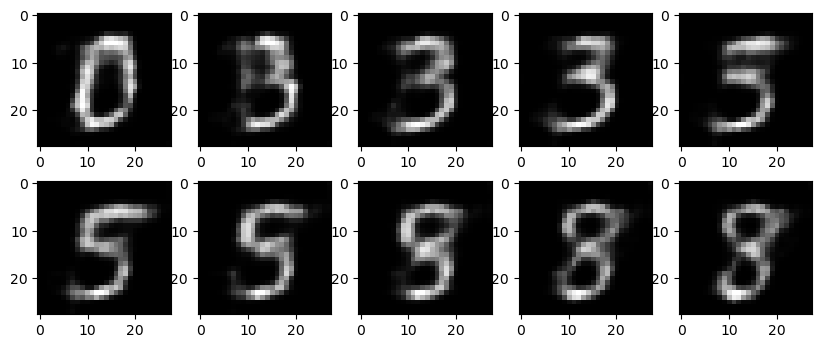

In [220]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
autoencoder.eval()
z = np.array([np.random.normal(0, 1, 4) for i in range(10)])
nums = torch.tensor([i for i in range(10)])
output = autoencoder.decode(torch.FloatTensor(z).to(device), nums.to(device)).detach().cpu().numpy()

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(output[i].reshape(28, 28, 1), cmap='gray')

### Latent Representations

In [214]:
mu_latent = None
with torch.no_grad():
    for i, (x_b, y_b) in enumerate(test_loader):
        mu = autoencoder(x_b.to(device), y_b.to(device))[0]
        mu = mu.cpu().detach()
        if i == 0:
            mu_latent = mu
            continue
        mu_latent = torch.vstack([mu_latent, mu])

mu_latent.shape

torch.Size([10000, 4])

In [216]:
from sklearn.manifold import TSNE
tsne = TSNE(2)
tsne_result = tsne.fit_transform(mu_latent.detach().numpy())

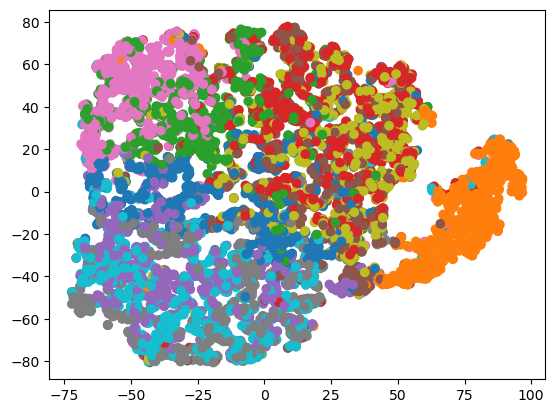

In [217]:
plt.scatter(x=tsne_result[:, 0], y=tsne_result[:, 1], c=test_dataset.targets.numpy(), cmap='tab10')
plt.show()

#### Let's make denoising AE

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t')
    df_attrs = pd.DataFrame(df_attrs)


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [4]:
all_photos, all_attrs = fetch_dataset()
all_photos = all_photos.astype(np.float32)
X = all_photos

In [5]:
X.shape

(13143, 64, 64, 3)

In [29]:
noise_factor = 0.2

In [30]:
train_data, test_data = data_utils.random_split(X, [0.8, 0.2])
train_loader = data_utils.DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
test_loader = data_utils.DataLoader(test_data, batch_size=32, shuffle=True, pin_memory=True)

In [31]:
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-3, amsgrad=True)

In [32]:
n_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = autoencoder(X_batch.to(device))[0]
        X_noisy = X_batch + noise_factor * torch.randn_like(X_batch)
        loss = criterion(reconstructed, X_noisy.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in test_loader:
          reconstructed = autoencoder(X_batch.to(device))[0]
          X_noisy = X_batch + noise_factor * torch.randn_like(X_batch)
          loss = criterion(reconstructed, X_noisy.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    print(f"Epoch {epoch} train loss {train_losses[-1]} val loss {val_losses[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 train loss 0.10870737376365255 val loss 0.05411202761243625
Epoch 1 train loss 0.05160995810589892 val loss 0.050674351403512154
Epoch 2 train loss 0.048211204437227595 val loss 0.046494258859430454
Epoch 3 train loss 0.0458558987044817 val loss 0.04436814592006695
Epoch 4 train loss 0.0451399042047447 val loss 0.04376185375703386
Epoch 5 train loss 0.04469157816519491 val loss 0.04358970616237227
Epoch 6 train loss 0.044364052261353266 val loss 0.04375336215977209
Epoch 7 train loss 0.04377326763328448 val loss 0.04340534338570503
Epoch 8 train loss 0.043488903656194275 val loss 0.04277309331010623
Epoch 9 train loss 0.04305826869190283 val loss 0.04321539321218629


In [33]:
test_batch = next(iter(test_loader))[:10]
test_batch.shape

torch.Size([10, 64, 64, 3])

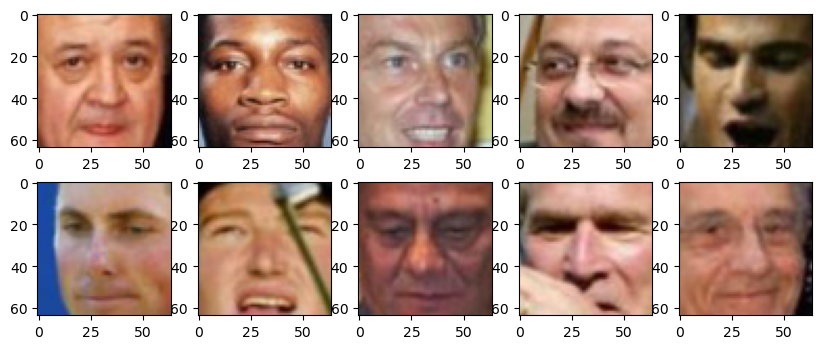

In [34]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_batch[i])

In [35]:
test_batch_noisy = test_batch + noise_factor * torch.randn_like(test_batch)

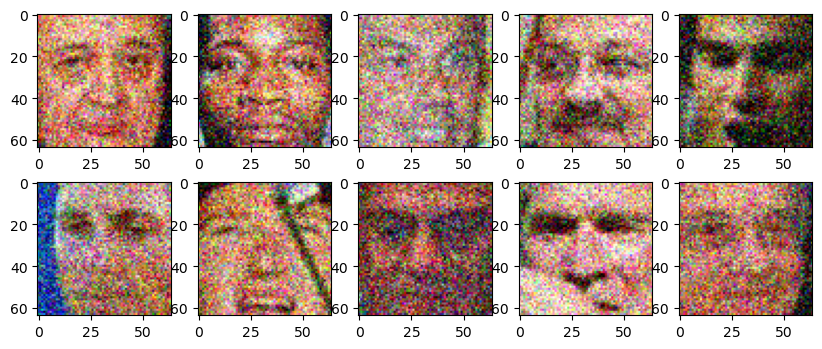

In [36]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.clip(test_batch_noisy[i], 0, 1))

In [37]:
autoencoder.eval()
preds = autoencoder(test_batch_noisy.to(device))[0].cpu().detach().numpy()

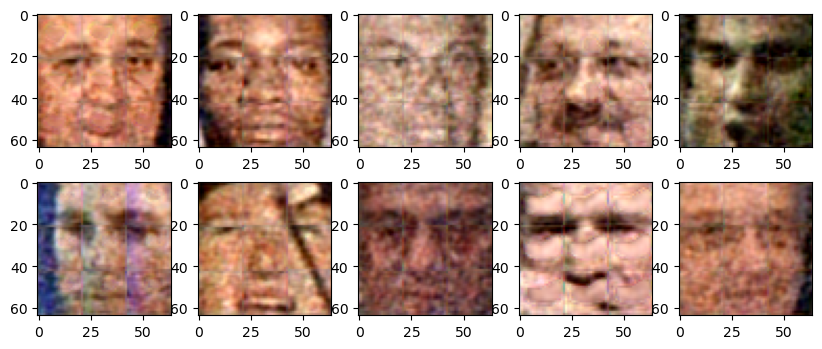

In [38]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.clip(preds[i], 0, 1))